In [1]:
# Based on Amar's matlab code
import numpy as np
from shapely.geometry import LineString, Point

import time

parameters = {}

parameters['time'] = time.strftime('%d%b%H%M', time.localtime())
parameters['doi_size'] = 1.5
parameters['alpha'] = 1e2
parameters['num_iter'] = 1,
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 1000  # number of samples per call to rx()
parameters['center_freq'] = 2.35e9  # Hz 2.4e9
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 40,  # dB
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1

def calculate_distance(point1, point2):
    return np.sqrt((point1[0]-point2[0])**2+(point1[1]-point2[1])**2)



def get_device_coordinates(parameters):
    doi_size = parameters['doi_size']
    num_deivces = len(parameters['device_indices'])

    line = LineString(((0.0, 0.0), (0.0, doi_size), (doi_size, doi_size), (doi_size, 0.0), (0.0, 0.0)))

    distances = np.linspace(0, line.length, num_deivces+1)

    points = [line.interpolate(distance) for distance in distances[:-1]]

    xx = [round(point.x, 3) for point in points]
    yy = [round(point.y, 3) for point in points]

    return xx, yy


def get_grid_coordinates(parameters):
    x = np.linspace(0.025, 1.475, int(parameters['doi_size']/parameters['grid_resolution']))

    y = np.linspace(0.025, 1.475, int(parameters['doi_size']/parameters['grid_resolution']))

    xx, yy = np.meshgrid(x, y)

    return xx, yy


device_xx, device_yy = get_device_coordinates(parameters)


grid_xx, grid_yy = get_grid_coordinates(parameters)

dist_txrx = np.zeros((parameters['num_devices'], parameters['num_devices']))
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        dist_txrx[tx][rx] = calculate_distance((device_xx[tx], device_yy[tx]), (device_xx[rx], device_yy[rx]))

dist_grid2device = np.zeros((int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution']), parameters['num_devices']))
for y in range(int(parameters['doi_size']/parameters['grid_resolution'])):
    for x in range(int(parameters['doi_size']/parameters['grid_resolution'])):
        for device in range(parameters['num_devices']):
            dist_grid2device[x][y][device] = (calculate_distance((grid_xx[x][y], grid_yy[x][y]), (device_xx[device], device_yy[device])))


In [2]:
F_RTI = np.zeros(((parameters['num_devices'])*(parameters['num_devices']-1), int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])))

idx = 0
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        if tx != rx:
            Thresh = 2*np.sqrt(dist_txrx[tx][rx]**2/4+parameters['detection_size']**2)
            foc_sum = dist_grid2device[:, :, rx] + dist_grid2device[:, :, tx]
            foc_sum[foc_sum>Thresh]=0
            foc_sum[foc_sum!=0]=1
            F_RTI[idx] = foc_sum
            idx += 1

F_RTI = F_RTI.reshape((parameters['num_devices'])*(parameters['num_devices']-1), -1)

In [3]:
start = time.time()

In [4]:
from functions import *

Pinc = np.load('result\Pinc.npy')
Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0],dtype=bool)].reshape(-1,1)

In [5]:
Ptot = np.load('result\Ptot.npy')
Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
Ptot = Ptot[~np.eye(Ptot.shape[0],dtype=bool)].reshape(-1,1)

In [6]:
Pryt = Pinc - Ptot

In [7]:
output = np.matmul(np.linalg.solve((np.matmul(F_RTI.T, F_RTI) + parameters['alpha'] * np.identity((int(parameters['doi_size']/parameters['grid_resolution'])**2))),  F_RTI.T), Pryt)

In [8]:
output = output / output.max()

In [9]:
output[output<0] = 0

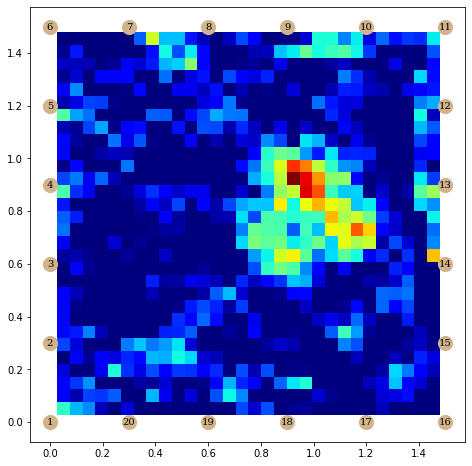

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

fontdict = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 10,
            }

plt.imshow(output.reshape((30,30)), extent=[0.025, 1.475, 0.025, 1.475], cmap='jet')

for i in range(parameters['num_devices']):
    plt.scatter(device_xx[i], device_yy[i], c='tan', s=200)
    plt.text(x=device_xx[i], y=device_yy[i]-0.01, s=i+1, fontdict=fontdict, ha='center')
plt.show()